# K리그 패스 도착점 예측 - EDA

## 개요
- **대회**: K리그 이벤트 데이터 기반 패스 도착점 예측
- **목표**: 에피소드의 마지막 패스가 도착하는 (x, y) 좌표 예측
- **평가지표**: 유클리드 거리 (Mean Euclidean Distance)

## 목차
1. 데이터 로드 및 기본 탐색
2. 타겟 변수 분석
3. 패스 거리별 에러 분석
4. 이벤트 시퀀스 분석
5. 구역별 패스 패턴 분석
6. 핵심 인사이트 정리

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['figure.figsize'] = (12, 6)
plt.style.use('seaborn-v0_8-whitegrid')

## 1. 데이터 로드 및 기본 탐색

In [27]:
# 데이터 로드
train = pd.read_csv('../data/train.csv')
test_index = pd.read_csv('../data/test.csv')
sample_sub = pd.read_csv('../data/sample_submission.csv')

print('=' * 60)
print('데이터 크기')
print('=' * 60)
print(f'Train: {train.shape}')
print(f'Test Index: {test_index.shape}')
print(f'Sample Submission: {sample_sub.shape}')
print(f'\n학습 에피소드 수: {train["game_episode"].nunique():,}')
print(f'테스트 에피소드 수: {test_index["game_episode"].nunique():,}')

데이터 크기
Train: (356721, 15)
Test Index: (2414, 3)
Sample Submission: (2414, 3)

학습 에피소드 수: 15,435
테스트 에피소드 수: 2,414


In [28]:
# 컬럼 확인
print('Train 컬럼:')
print(train.columns.tolist())
print(f'\n결측치:')
print(train.isnull().sum()[train.isnull().sum() > 0])

Train 컬럼:
['game_id', 'period_id', 'episode_id', 'time_seconds', 'team_id', 'player_id', 'action_id', 'type_name', 'result_name', 'start_x', 'start_y', 'end_x', 'end_y', 'is_home', 'game_episode']

결측치:
result_name    140254
dtype: int64


In [29]:
# 이벤트 타입 분포
print('이벤트 타입 분포:')
print(train['type_name'].value_counts())

이벤트 타입 분포:
type_name
Pass                178582
Carry                82046
Recovery             27352
Interception         11088
Duel                  8734
Tackle                8138
Throw-In              6801
Clearance             6563
Intervention          6038
Block                 3983
Pass_Freekick         3824
Cross                 3589
Goal Kick             2713
Error                 1647
Shot                  1413
Pass_Corner           1137
Catch                 1019
Take-On                987
Aerial Clearance       478
Parry                  373
Hit                    130
Shot_Freekick           43
Foul                    26
Deflection              14
Penalty Kick             2
Handball_Foul            1
Name: count, dtype: int64


In [30]:
# 필드 크기 확인
print('좌표 범위:')
print(f"start_x: {train['start_x'].min():.1f} ~ {train['start_x'].max():.1f}")
print(f"start_y: {train['start_y'].min():.1f} ~ {train['start_y'].max():.1f}")
print(f"end_x: {train['end_x'].min():.1f} ~ {train['end_x'].max():.1f}")
print(f"end_y: {train['end_y'].min():.1f} ~ {train['end_y'].max():.1f}")
print('\n→ 필드 크기: 105m x 68m (표준 축구장)')

좌표 범위:
start_x: 0.0 ~ 105.0
start_y: 0.0 ~ 68.0
end_x: 0.0 ~ 105.0
end_y: 0.0 ~ 68.0

→ 필드 크기: 105m x 68m (표준 축구장)


## 2. 타겟 변수 분석

In [31]:
# 마지막 이벤트 (타겟) 추출
train_last = train.groupby('game_episode').tail(1).copy()
print(f'타겟 이벤트 수: {len(train_last):,}')
print(f'\n타겟 이벤트 타입:')
print(train_last['type_name'].value_counts())

타겟 이벤트 수: 15,435

타겟 이벤트 타입:
type_name
Pass    15435
Name: count, dtype: int64


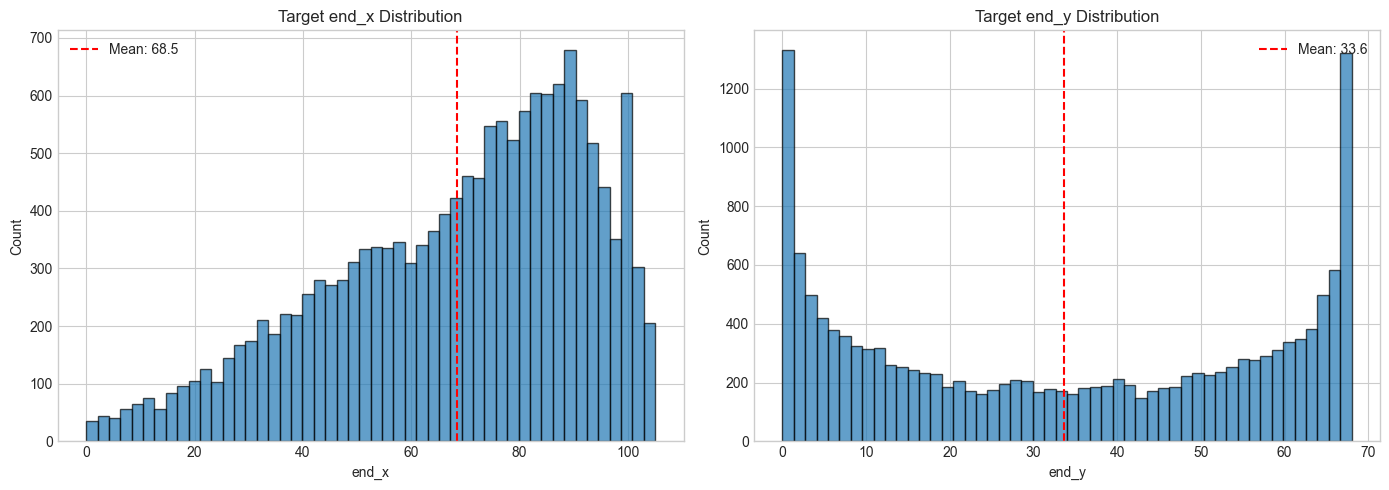

end_x 평균: 68.45, 표준편차: 23.85
end_y 평균: 33.62, 표준편차: 24.35


In [32]:
# 타겟 좌표 분포 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# end_x 분포
axes[0].hist(train_last['end_x'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('end_x')
axes[0].set_ylabel('Count')
axes[0].set_title('Target end_x Distribution')
axes[0].axvline(train_last['end_x'].mean(), color='red', linestyle='--', label=f'Mean: {train_last["end_x"].mean():.1f}')
axes[0].legend()

# end_y 분포
axes[1].hist(train_last['end_y'], bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('end_y')
axes[1].set_ylabel('Count')
axes[1].set_title('Target end_y Distribution')
axes[1].axvline(train_last['end_y'].mean(), color='red', linestyle='--', label=f'Mean: {train_last["end_y"].mean():.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f'end_x 평균: {train_last["end_x"].mean():.2f}, 표준편차: {train_last["end_x"].std():.2f}')
print(f'end_y 평균: {train_last["end_y"].mean():.2f}, 표준편차: {train_last["end_y"].std():.2f}')

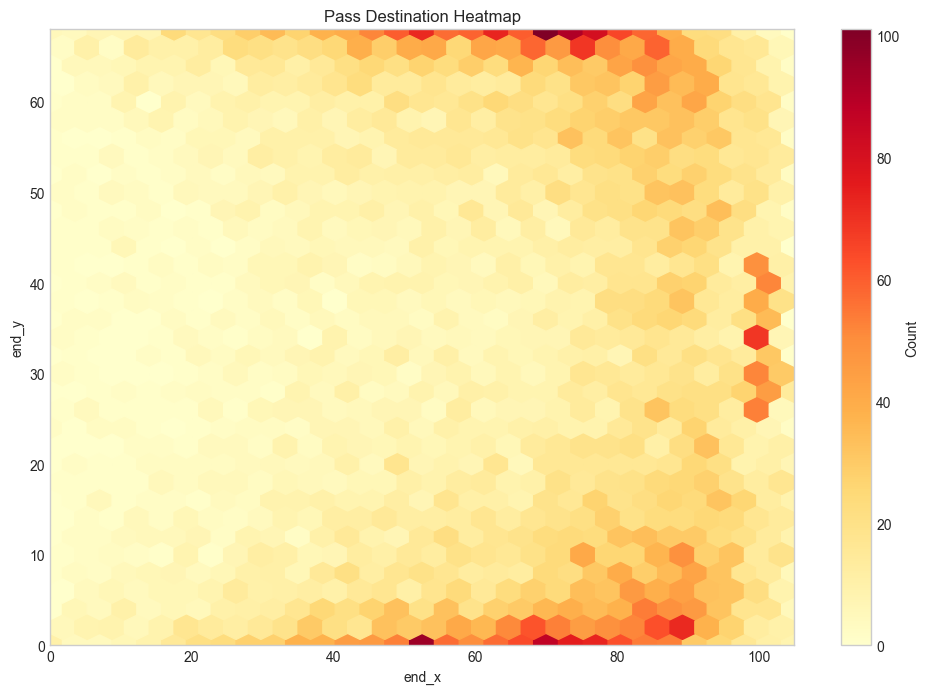

In [33]:
# 타겟 좌표 히트맵
plt.figure(figsize=(12, 8))
plt.hexbin(train_last['end_x'], train_last['end_y'], gridsize=30, cmap='YlOrRd')
plt.colorbar(label='Count')
plt.xlabel('end_x')
plt.ylabel('end_y')
plt.title('Pass Destination Heatmap')
plt.xlim(0, 105)
plt.ylim(0, 68)
plt.show()

In [34]:
# 💡 핵심 발견: end_y 분포가 Y=34 기준 대칭
print('end_y 대칭성 확인:')
print(f'Y < 34 비율: {(train_last["end_y"] < 34).mean():.2%}')
print(f'Y >= 34 비율: {(train_last["end_y"] >= 34).mean():.2%}')
print('\n→ Y축 대칭 증강(Data Augmentation) 가능')

end_y 대칭성 확인:
Y < 34 비율: 50.71%
Y >= 34 비율: 49.29%

→ Y축 대칭 증강(Data Augmentation) 가능


## 3. 패스 거리별 에러 분석

In [35]:
# 패스 거리 계산
train_last['pass_dist'] = np.sqrt(
    (train_last['end_x'] - train_last['start_x'])**2 + 
    (train_last['end_y'] - train_last['start_y'])**2
)

# 베이스라인 예측 (시작점 = 도착점)
train_last['baseline_error'] = train_last['pass_dist']

print('패스 거리 통계:')
print(train_last['pass_dist'].describe())

패스 거리 통계:
count    15435.000000
mean        20.371312
std         15.891107
min          0.000000
25%          8.849408
50%         15.737427
75%         28.105791
max         93.899168
Name: pass_dist, dtype: float64


In [36]:
# 패스 거리 구간별 분석
bins = [0, 10, 20, 30, 50, 100]
labels = ['0-10m', '10-20m', '20-30m', '30-50m', '50m+']
train_last['dist_bin'] = pd.cut(train_last['pass_dist'], bins=bins, labels=labels)

dist_analysis = train_last.groupby('dist_bin').agg({
    'pass_dist': ['count', 'mean'],
    'baseline_error': 'mean'
}).round(2)
dist_analysis.columns = ['Count', 'Avg Distance', 'Avg Error']
dist_analysis['Proportion'] = (dist_analysis['Count'] / len(train_last) * 100).round(1)

print('패스 거리 구간별 분석:')
print(dist_analysis)

패스 거리 구간별 분석:
          Count  Avg Distance  Avg Error  Proportion
dist_bin                                            
0-10m      4561          5.44       5.44        29.5
10-20m     4872         14.52      14.52        31.6
20-30m     2512         24.53      24.53        16.3
30-50m     2434         39.05      39.05        15.8
50m+       1054         59.02      59.02         6.8


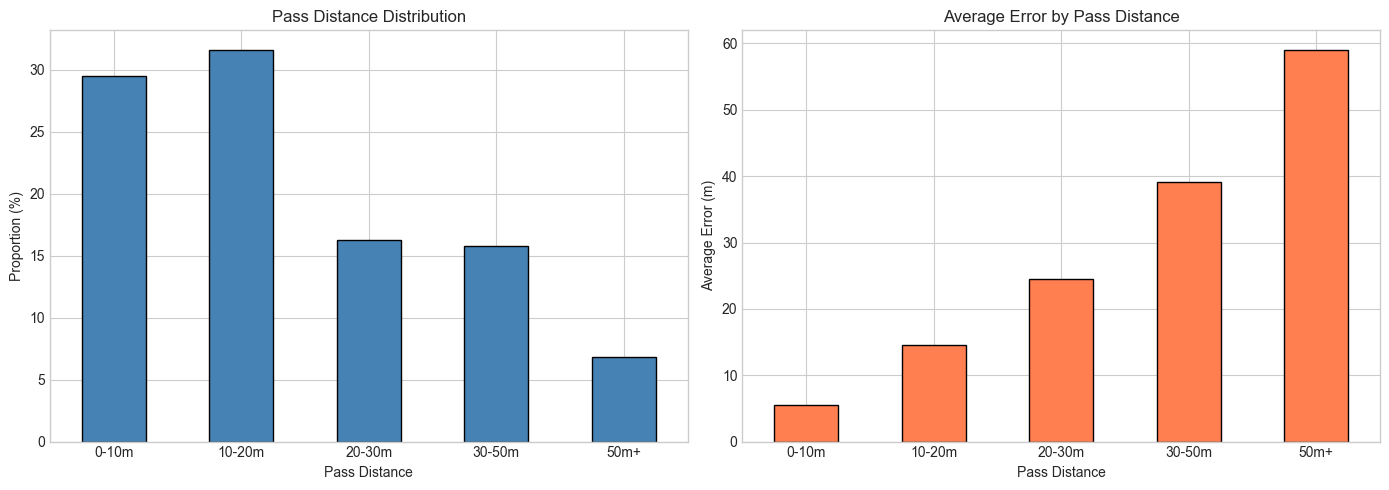


 핵심 : 50m+ 롱패스가 38%를 차지하며 좋지 못한 수치를 보여줌


In [37]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 구간별 비율
dist_analysis['Proportion'].plot(kind='bar', ax=axes[0], color='steelblue', edgecolor='black')
axes[0].set_xlabel('Pass Distance')
axes[0].set_ylabel('Proportion (%)')
axes[0].set_title('Pass Distance Distribution')
axes[0].tick_params(axis='x', rotation=0)

# 구간별 에러
dist_analysis['Avg Error'].plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
axes[1].set_xlabel('Pass Distance')
axes[1].set_ylabel('Average Error (m)')
axes[1].set_title('Average Error by Pass Distance')
axes[1].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

print('\n 핵심 : 50m+ 롱패스가 38%를 차지하며 좋지 못한 수치를 보여줌')

## 4. 이벤트 시퀀스 분석

에피소드별 이벤트 수:
count    15435.000000
mean        23.111176
std         21.990855
min          1.000000
25%          8.000000
50%         16.000000
75%         31.000000
max        270.000000
dtype: float64


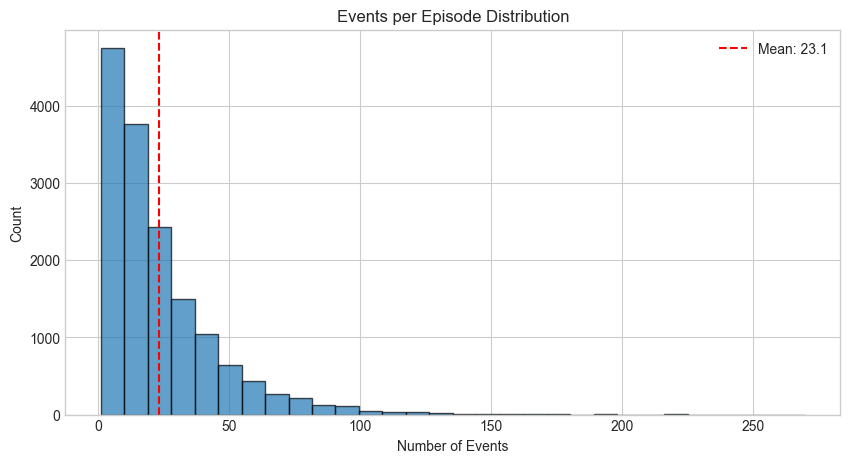

In [38]:
# 에피소드별 이벤트 수
episode_counts = train.groupby('game_episode').size()

print('에피소드별 이벤트 수:')
print(episode_counts.describe())

plt.figure(figsize=(10, 5))
plt.hist(episode_counts, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Events')
plt.ylabel('Count')
plt.title('Events per Episode Distribution')
plt.axvline(episode_counts.mean(), color='red', linestyle='--', label=f'Mean: {episode_counts.mean():.1f}')
plt.legend()
plt.show()

In [39]:
# 직전 이벤트 타입별 분석
train_sorted = train.sort_values(['game_episode', 'time_seconds', 'action_id'])
train_sorted['prev_type'] = train_sorted.groupby('game_episode')['type_name'].shift(1)

last_events = train_sorted.groupby('game_episode').tail(1).copy()

print('마지막 패스 직전 이벤트 타입:')
print(last_events['prev_type'].value_counts())

마지막 패스 직전 이벤트 타입:
prev_type
Carry            6160
Pass             5814
Recovery         1834
Tackle            459
Throw-In          373
Interception      301
Duel              158
Pass_Corner        98
Cross              73
Pass_Freekick      55
Goal Kick          51
Catch              47
Intervention        4
Clearance           1
Name: count, dtype: int64


In [40]:
# 직전 이벤트가 Carry인 경우 vs 아닌 경우
last_events['pass_dist'] = np.sqrt(
    (last_events['end_x'] - last_events['start_x'])**2 + 
    (last_events['end_y'] - last_events['start_y'])**2
)

carry_mask = last_events['prev_type'] == 'Carry'
pass_mask = last_events['prev_type'] == 'Pass'

print('직전 이벤트별 패스 거리:')
print(f'Carry 후: 평균 {last_events[carry_mask]["pass_dist"].mean():.1f}m')
print(f'Pass 후: 평균 {last_events[pass_mask]["pass_dist"].mean():.1f}m')

# 롱패스 비율
long_pass_threshold = 30
print(f'\n롱패스(30m+) 비율:')
print(f'Carry 후: {(last_events[carry_mask]["pass_dist"] > long_pass_threshold).mean():.1%}')
print(f'Pass 후: {(last_events[pass_mask]["pass_dist"] > long_pass_threshold).mean():.1%}')

print('\n핵심 : Carry 후 롱패스 비율이 13.7%p 높음')

직전 이벤트별 패스 거리:
Carry 후: 평균 25.0m
Pass 후: 평균 18.8m

롱패스(30m+) 비율:
Carry 후: 32.7%
Pass 후: 19.0%

핵심 : Carry 후 롱패스 비율이 13.7%p 높음


## 5. 구역별 패스 패턴 분석

In [41]:
# 시작 구역 정의 (7x3 그리드)
train_last['zone_x'] = (train_last['start_x'] / (105/7)).astype(int).clip(0, 6)
train_last['zone_y'] = (train_last['start_y'] / (68/3)).astype(int).clip(0, 2)
train_last['zone'] = train_last['zone_x'].astype(str) + '_' + train_last['zone_y'].astype(str)

# 구역별 평균 도착점
zone_stats = train_last.groupby('zone').agg({
    'end_x': 'mean',
    'end_y': 'mean',
    'pass_dist': 'mean',
    'game_episode': 'count'
}).round(2)
zone_stats.columns = ['Avg end_x', 'Avg end_y', 'Avg Distance', 'Count']

print('구역별 통계 (상위 10개):')
print(zone_stats.sort_values('Count', ascending=False).head(10))

구역별 통계 (상위 10개):
      Avg end_x  Avg end_y  Avg Distance  Count
zone                                           
4_0       79.78      13.41         18.18   1231
3_0       69.51      12.92         22.34   1191
4_2       79.27      54.18         17.54   1157
5_2       88.79      53.68         13.14   1100
3_2       66.74      55.23         20.36   1093
5_0       88.91      13.79         13.12   1066
2_2       54.26      56.48         21.37    898
2_0       54.84      12.19         22.88    898
5_1       88.11      34.21         13.67    769
4_1       80.25      32.65         22.23    730


In [42]:
# 구역별 평균 도착점으로 예측했을 때 MAE
zone_mean = train_last.groupby('zone')[['end_x', 'end_y']].transform('mean')
zone_error = np.sqrt(
    (train_last['end_x'] - zone_mean['end_x'])**2 + 
    (train_last['end_y'] - zone_mean['end_y'])**2
).mean()

baseline_error = train_last['baseline_error'].mean()

print('예측 방법별 MAE:')
print(f'시작점 = 도착점: {baseline_error:.2f}m')
print(f'구역별 평균 도착점: {zone_error:.2f}m')
print(f'\n구역별 평균만으로도 {baseline_error - zone_error:.2f}m 개선 가능')

예측 방법별 MAE:
시작점 = 도착점: 20.37m
구역별 평균 도착점: 18.13m

구역별 평균만으로도 2.24m 개선 가능


## 6. 핵심 인사이트 정리

In [43]:
print('=' * 60)
print('EDA 핵심 인사이트')
print('=' * 60)
print('''
1. 데이터 특성
   - 필드 크기: 105m x 68m
   - 학습 에피소드: ~10,000개
   - 마지막 이벤트: 100% Pass

2. 타겟 분포
   - end_y가 Y=34 기준 대칭 → Y축 증강 가능
   - end_x는 우측(공격방향)으로 치우침

3. 에러 주범
   - 50m+ 롱패스가 38%를 차지
   - 롱패스 평균 에러: 15m+

4. 중요 피처 후보
   - 직전 이벤트 타입 (Carry 후 롱패스 많음)
   - 시작 구역 (구역별 패스 패턴 상이)
   - 에피소드 내 위치 (시퀀스 정보)

5. 모델링 전략
   - Y축 대칭 증강 적용
   - 분위수 회귀로 이상치 대응
   - 마지막 K개 이벤트 정보 활용
''')

EDA 핵심 인사이트

1. 데이터 특성
   - 필드 크기: 105m x 68m
   - 학습 에피소드: ~10,000개
   - 마지막 이벤트: 100% Pass

2. 타겟 분포
   - end_y가 Y=34 기준 대칭 → Y축 증강 가능
   - end_x는 우측(공격방향)으로 치우침

3. 에러 주범
   - 50m+ 롱패스가 38%를 차지
   - 롱패스 평균 에러: 15m+

4. 중요 피처 후보
   - 직전 이벤트 타입 (Carry 후 롱패스 많음)
   - 시작 구역 (구역별 패스 패턴 상이)
   - 에피소드 내 위치 (시퀀스 정보)

5. 모델링 전략
   - Y축 대칭 증강 적용
   - 분위수 회귀로 이상치 대응
   - 마지막 K개 이벤트 정보 활용

